In [197]:
import seaborn as sns
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Classification

In [198]:
df = pd.read_csv("diamonds.csv")
df = df.drop(df.columns[0], axis=1)

## Information

In [199]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [200]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [201]:
df.shape

(53940, 10)

In [202]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

## Nettoyage de données

In [203]:
cut_map = {
    'Fair': 0, 
    'Good': 1, 
    'Very Good': 2, 
    'Premium': 3, 
    'Ideal': 4
}

color_map = {
    'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6
}

clarity_map = {
    'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7
}


df['cut'] = df['cut'].map(cut_map)
df['color'] = df['color'].map(color_map)
df['clarity'] = df['clarity'].map(clarity_map)


print(df.head())

   carat  cut  color  clarity  depth  table  price     x     y     z
0   0.23    4      5        1   61.5   55.0    326  3.95  3.98  2.43
1   0.21    3      5        2   59.8   61.0    326  3.89  3.84  2.31
2   0.23    1      5        4   56.9   65.0    327  4.05  4.07  2.31
3   0.29    3      1        3   62.4   58.0    334  4.20  4.23  2.63
4   0.31    1      0        1   63.3   58.0    335  4.34  4.35  2.75


Ajout de fearures pour essayer de mieux utiliser les données à disposition

In [204]:
# --- DEBUT DU FEATURE ENGINEERING ---

# 1. Interactions Table / Depth (CRUCIAL pour prédire le "Cut")
# La qualité de la coupe dépend physiquement du ratio entre la table et la profondeur.
# Ces deux colonnes seules sont difficiles à interpréter pour le réseau,
# mais leur différence ou leur ratio est très parlant.
# df['table_depth_diff'] = df['table'] - df['depth']
# df['table_depth_ratio'] = df['table'] / df['depth']

# 2. Le Volume (Si x, y, z sont des INPUTS)
# ATTENTION : Si vous utilisez x, y, z comme cibles (outputs) pour la régression,
# NE METTEZ PAS cette ligne (sinon c'est de la triche/data leakage).
# Si x, y, z sont des entrées pour prédire le "Cut", alors gardez-la :
# if 'x' in df.columns and 'y' in df.columns and 'z' in df.columns:
#     df['volume'] = df['x'] * df['y'] * df['z']
#     # On remplace les volumes nuls (erreurs de saisie) par une petite valeur
#     df['volume'] = df['volume'].replace(0, 0.01)

# 3. Ratio Dimensions (L/W ratio)
# Un diamant rond doit avoir un ratio longueur/largeur proche de 1.
# S'il est ovale, le "Cut" est moins bon.
# On ajoute une petite valeur (1e-9) pour éviter la division par zéro
# df['length_width_ratio'] = df['x'] / (df['y'] + 1e-9)

# --- FIN DU FEATURE ENGINEERING ---


In [205]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


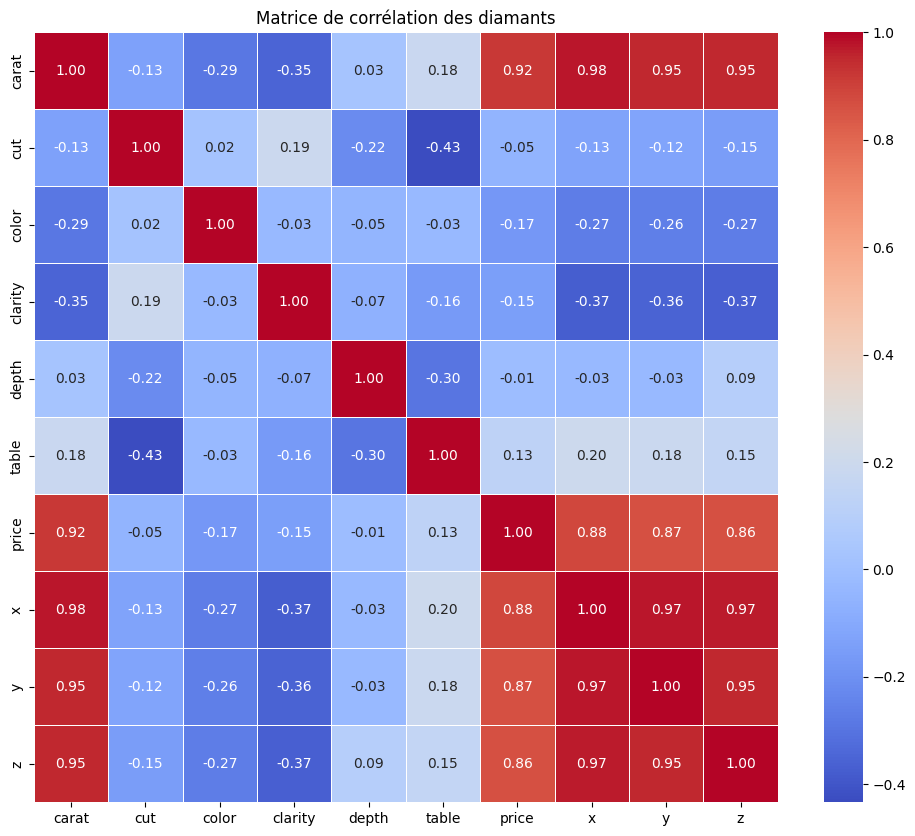

In [206]:
# Calcul de la matrice de corrélation sur le dataframe nettoyé
corr_matrix = df.corr()

# Création de la Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation des diamants")
plt.show()

C:\Users\lepot\AppData\Local\Temp\ipykernel_24564\3959851675.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_plot, x='cut_label', order=order, palette='viridis')


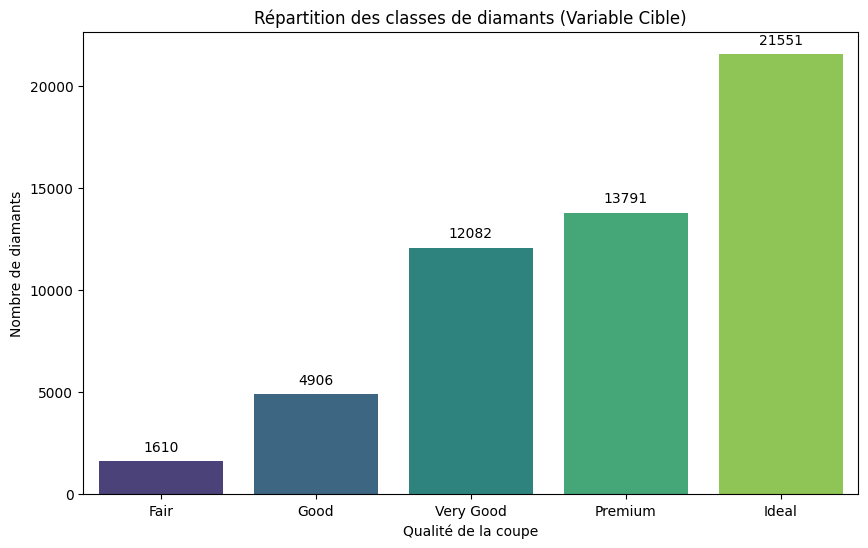

In [207]:
# 1. Créer une copie temporaire pour ne pas modifier vos données d'entraînement
df_plot = df.copy()

# 2. Remettre les étiquettes pour la lisibilité
inv_cut_map = {0: 'Fair', 1: 'Good', 2: 'Very Good', 3: 'Premium', 4: 'Ideal'}
df_plot['cut_label'] = df_plot['cut'].map(inv_cut_map)

# 3. Créer le graphique
plt.figure(figsize=(10, 6))
order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] # Ordre logique
ax = sns.countplot(data=df_plot, x='cut_label', order=order, palette='viridis')

# Ajouter les nombres au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Répartition des classes de diamants (Variable Cible)')
plt.xlabel('Qualité de la coupe')
plt.ylabel('Nombre de diamants')
plt.show()

## Model

In [ ]:
target = ['cut']
X = df.drop(columns=target)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [210]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(100, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(100, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(8, activation='softmax')
])

c:\Users\lepot\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [211]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [212]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 100)            │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,208 (90.66 KB)

 Trainable params: 22,608 (88.31 KB)

 Non-trainable params: 600 (2.34 KB)

In [213]:
classes_uniques = np.unique(y_train)
poids = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_uniques,
    y=y_train.values.ravel() 
)

poids_dict = dict(zip(classes_uniques, poids))

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.5,              # On divise le LR par 2 si ça stagne (ex: 0.001 -> 0.0005)
    patience=2,              # On attend 2 epochs sans amélioration avant de réduire
    min_lr=1e-6,             # On ne descend pas en dessous de ce seuil
    verbose=1                # Affiche un message quand le LR change
)

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test),callbacks=[early_stopping,lr_scheduler], verbose = 1, class_weight=poids_dict)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy : {test_acc:2f}")

Epoch 1/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2765 - loss: 1.6255 - val_accuracy: 0.4092 - val_loss: 1.4036 - learning_rate: 0.0100
Epoch 2/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3463 - loss: 1.4088 - val_accuracy: 0.4359 - val_loss: 1.3264 - learning_rate: 0.0100
Epoch 3/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3549 - loss: 1.3815 - val_accuracy: 0.3675 - val_loss: 1.6824 - learning_rate: 0.0100
Epoch 4/50
1348/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3593 - loss: 1.3820
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3582 - loss: 1.3776 - val_accuracy: 0.4061 - val_loss: 1.4297 - learning_rate: 0.0100
Epoch 5/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3925 - loss: 1.2870 - val_accuracy: 0.4698 - val_loss: 1.2482 - learning_rate: 0.0050
Epoch 6/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.3968 - 

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


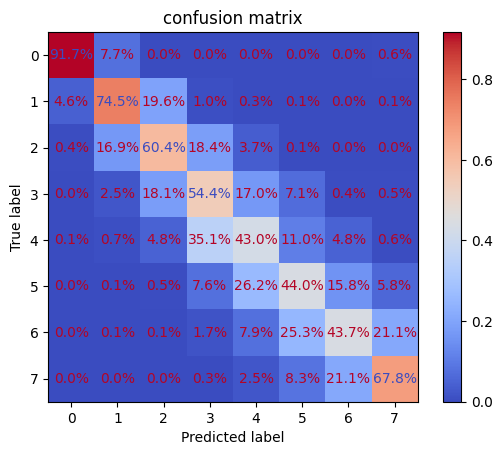

In [214]:
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred_classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='coolwarm', values_format='.1%')
plt.title("confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig("confusionMatrixMlp.png", dpi=300, bbox_inches='tight')
plt.show()